## 0.1 - Import tensorflow and list GPU devices

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if gpus:
    print("GPUs disponibles :")
    for gpu in gpus:
        print(gpu)
else:
    print("Aucun GPU disponible")

[]
Aucun GPU disponible


## 0.2 - Every imports

In [2]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Reshape, LSTM, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

## 0.3 - Setup variables

In [3]:
input_shape = 128
directory_path = './data'
augmented_path = f"{directory_path}_augment"

## 0.4 - Augment Data (generate more rituals.)

In [13]:
import os
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

input_shape = 128

def load_and_preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=1)
    img = tf.image.resize(img, [input_shape, input_shape])
    img = tf.cast(img, tf.float32).numpy().squeeze()
    return img

def binarize_image(image):
    return np.where(image > 127, 255, 0).astype(np.uint8)

def apply_augmentation(image, x_shift=0, y_shift=0, angle=0):
    img = Image.fromarray(image.astype(np.uint8))
    img = img.transform(img.size, Image.AFFINE, (1, 0, x_shift, 0, 1, y_shift), fillcolor=0)
    img = img.rotate(angle, fillcolor=0)
    return np.array(img)

def augment_and_save_images(src_dir, dst_dir):
    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)
    os.makedirs(dst_dir, exist_ok=True)

    augmentations = [
        {"x_shift": 5, "y_shift": 0, "angle": 0},
        {"x_shift": -5, "y_shift": 0, "angle": 0},
        {"x_shift": 0, "y_shift": 5, "angle": 0},
        {"x_shift": 0, "y_shift": -5, "angle": 0},
        {"x_shift": 3, "y_shift": 3, "angle": 0},
        {"x_shift": -3, "y_shift": -3, "angle": 0},
        {"x_shift": 0, "y_shift": 0, "angle": 10},
        {"x_shift": 0, "y_shift": 0, "angle": -10},
        {"x_shift": 0, "y_shift": 0, "angle": 15},
        {"x_shift": 0, "y_shift": 0, "angle": -15},
        {"x_shift": 4, "y_shift": 0, "angle": 10},
        {"x_shift": -4, "y_shift": 0, "angle": -10},
        {"x_shift": 0, "y_shift": 4, "angle": 15},
        {"x_shift": 0, "y_shift": -4, "angle": -15},
        {"x_shift": 2, "y_shift": 4, "angle": 25},
        {"x_shift": 1, "y_shift": -4, "angle": -25},
        {"x_shift": 2, "y_shift": 4, "angle": 5},
        {"x_shift": 1, "y_shift": -4, "angle": -5}
    ]

    for label in os.listdir(src_dir):
        label_path = os.path.join(src_dir, label)
        if os.path.isdir(label_path):
            dst_label_path = os.path.join(dst_dir, label)
            os.makedirs(dst_label_path, exist_ok=True)
            for filename in tqdm(os.listdir(label_path), desc=f"Augmenting {label}"):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    src_file = os.path.join(label_path, filename)
                    img = load_and_preprocess_image(src_file)

                    for i, aug in enumerate(augmentations):
                        aug_img = apply_augmentation(img, **aug)
                        aug_img = binarize_image(aug_img)
                        aug_img_pil = Image.fromarray(aug_img)
                        name, ext = os.path.splitext(filename)
                        aug_img_pil.save(os.path.join(dst_label_path, f"{name}_aug{i+1}{ext}"))

augment_and_save_images(directory_path, augmented_path)
print("Augmentation completed and saved in:", augmented_path)


Augmenting choumir: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.69it/s]

Augmentation completed and saved in: ./data_augment


## 1.0 - Collect images and classify them

In [14]:
def load_and_preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=1)  # 1 canal pour image en niveaux de gris
    img = tf.image.resize(img, [input_shape, input_shape])
    img = tf.cast(img, tf.float32)
    # Seuillage binaire : tout pixel > 127 devient blanc (255), sinon noir (0)
    img = tf.where(img > 127, 255.0, 0.0)
    img = img.numpy()  # Conversion en NumPy
    return img

def load_images_from_directory(directory_path, max_images_per_label=None):
    image_paths = []
    labels = []
    label_names = []

    for label in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label)
        print(f"Actually load : {label} with size : {len(os.listdir(label_path))}")
        if os.path.isdir(label_path):
            label_image_count = 0
            
            for filename in os.listdir(label_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    if max_images_per_label is not None and label_image_count >= max_images_per_label:
                        break
                    image_paths.append(os.path.join(label_path, filename))
                    labels.append(label)
                    label_image_count += 1
                    if label not in label_names:
                        label_names.append(label)
    
    label_names.sort()
    return image_paths, labels, label_names

def images_to_numpy(image_paths, labels, label_names):
    images = []
    for path in tqdm(image_paths, desc="Processing images", unit="image"):
        image = load_and_preprocess_image(path)
        images.append(image)
    
    labels = [label_names.index(label) for label in labels]
    
    print("Converting images to NumPy array...")
    images = np.array(images)
    return images, np.array(labels)

max_images_per_label = 1000000
image_paths, labels, label_names = load_images_from_directory(augmented_path, max_images_per_label=max_images_per_label)
images, labels = images_to_numpy(image_paths, labels, label_names)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
num_classes = len(label_names)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"Total images: {len(images)}")
print(f"Training images: {X_train.shape[0]}, Test images: {X_test.shape[0]}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {label_names}")


Actually load : chimtir with size : 54
Actually load : not_a with size : 108
Actually load : choumir with size : 18


Processing images: 100%|██████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 2185.29image/s]

Converting images to NumPy array...
Total images: 180
Training images: 144, Test images: 36
Number of classes: 3
Class names: ['chimtir', 'choumir', 'not_a']


## 1.1 - Show a little matplotlib (isn't that beautiful)

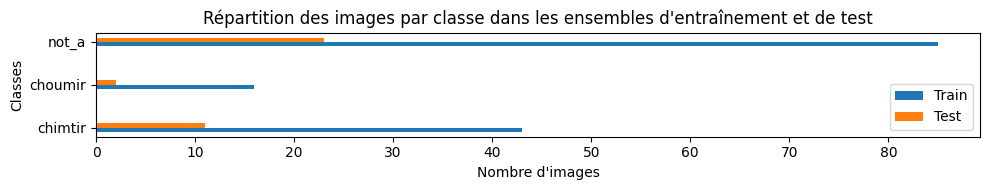

In [15]:
import matplotlib.pyplot as plt

train_counts = np.sum(y_train, axis=0) 
test_counts = np.sum(y_test, axis=0)

fig, ax = plt.subplots(figsize=(10, 2))
index = np.arange(len(label_names))
bar_height = 0.1
train_bar = ax.barh(index, train_counts, bar_height, label='Train')
test_bar = ax.barh(index + bar_height, test_counts, bar_height, label='Test')

# Ajouter des étiquettes
ax.set_ylabel('Classes')
ax.set_xlabel('Nombre d\'images')
ax.set_title('Répartition des images par classe dans les ensembles d\'entraînement et de test')
ax.set_yticks(index + bar_height / 2)
ax.set_yticklabels(label_names)
ax.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

## 1.2 - Show some images (just to be sure)

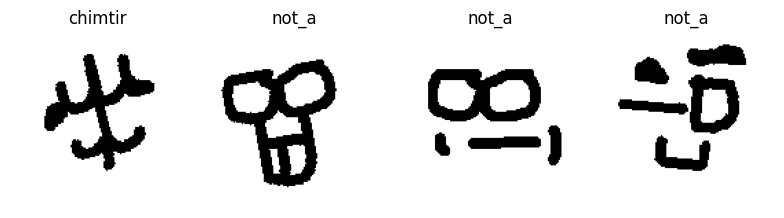

In [16]:
def preview_images(images, labels, label_names, n=9):
    plt.figure(figsize=(8, 8))
    indices = np.random.choice(len(images), n, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='binary')  # Affichage noir/blanc
        plt.title(label_names[labels[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

preview_images(X_train, np.argmax(y_train, axis=1), label_names, n=4)

## 2.0 - Define model & function

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape, input_shape, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())  # Remplace Flatten
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/homebrew/Caskroom/miniconda/base/envs/ritualcnn/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,571 (428.01 KB)

 Trainable params: 109,571 (428.01 KB)

 Non-trainable params: 0 (0.00 B)

## 2.1 - Training !

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5597 - loss: 4.6365

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5304 - loss: 4.6537 - val_accuracy: 0.2414 - val_loss: 4.0172
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3309 - loss: 4.9939

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3652 - loss: 4.5097 - val_accuracy: 0.6207 - val_loss: 1.7756
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5293 - loss: 2.2673

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5130 - loss: 1.9217 - val_accuracy: 0.6207 - val_loss: 0.8464
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4957 - loss: 1.2007 - val_accuracy: 0.6207 - val_loss: 0.9439
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4399 - loss: 1.2610 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5043 - loss: 1.1141 - val_accuracy: 0.6207 - val_loss: 0.8200
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5345 - loss: 1.0366

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5391 - loss: 0.9803 - val_accuracy: 0.6207 - val_loss: 0.8144
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6318 - loss: 0.8888

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6000 - loss: 0.9004 - val_accuracy: 0.6207 - val_loss: 0.7887
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5936 - loss: 0.8577

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5826 - loss: 0.8670 - val_accuracy: 0.6207 - val_loss: 0.7731
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6674 - loss: 0.7710

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6435 - loss: 0.8076 - val_accuracy: 0.6897 - val_loss: 0.7500
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6774 - loss: 0.7953

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7043 - loss: 0.7760 - val_accuracy: 0.6207 - val_loss: 0.7141
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6939 - loss: 0.7059

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7130 - loss: 0.7035 - val_accuracy: 0.6207 - val_loss: 0.6858
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6574 - loss: 0.7586

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6870 - loss: 0.7571 - val_accuracy: 0.8621 - val_loss: 0.6422
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7212 - loss: 0.6583

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7391 - loss: 0.6626 - val_accuracy: 0.6552 - val_loss: 0.5890
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7260 - loss: 0.6122 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7217 - loss: 0.6203 - val_accuracy: 0.8621 - val_loss: 0.5484
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7568 - loss: 0.6854

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7565 - loss: 0.6603 - val_accuracy: 0.7586 - val_loss: 0.5210
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7117 - loss: 0.6171

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7217 - loss: 0.5917 - val_accuracy: 0.8621 - val_loss: 0.4573
Epoch 17/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7577 - loss: 0.5626

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7652 - loss: 0.5707 - val_accuracy: 0.8621 - val_loss: 0.4092
Epoch 18/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8393 - loss: 0.4852

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8261 - loss: 0.5018 - val_accuracy: 0.8621 - val_loss: 0.3801
Epoch 19/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8467 - loss: 0.4528 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8348 - loss: 0.4619 - val_accuracy: 0.8621 - val_loss: 0.3378
Epoch 20/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8415 - loss: 0.4400 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8348 - loss: 0.4506 - val_accuracy: 0.8621 - val_loss: 0.3094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9167 - loss: 0.3014
Test Accuracy: 0.9167, Test Loss: 0.3014
